# Multi-step forecasting: linear regression.

In the previous notebook, we forecasted hourly pollutant concentrations per hour over the next 24 hours, utilizing a simple or naive forecast, where the future concentration was given by the concentration in the previous hour.

In this notebook, we will add a small layer of complexity where we return the value of the pollutant concentration in the next hour as a linear function of the concentration in the previous hour.

**For simplicity, we will only forecast the concentration of Carbon Monoxide (CO).**


## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# For missing data imputation.
from feature_engine.imputation import MeanMedianImputer
# For our feature engineering class
from sklearn.base import BaseEstimator, TransformerMixin
# For the linear regression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Load Data

In [3]:
# New:

# We pack all data preparation steps from the
# previous notebook in a function.


def load_data():

    # Data lives here.
    filename = "../datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data[(data.index >= "2004-04-01") & (data.index <= "2005-04-30")]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]

    return data

In [4]:
# Load data with our new function.

data = load_data()

data.head()

,CO_sensor
Date_Time,
2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,1028.0


# Split data into train and test

We "train" the model on a training set and evaluate its performance on a test set. This is good practice to avoid leaking information to the model and to conduct a fair evaluation on a completely new dataset.

In this case, differently from the previous notebook, our model does learn parameters from the data. So we want to be sure, we train the model only with the training set.

In [5]:
# Split the data

X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= "2005-03-04"]

# Lag Feature

To predict the target as a linear function of its concentration in the previous hour, we need to create **a new feature** that will be the input variable to our linear model. 

This feature is the pollutant concentration in the previous hour.

In section 2, we created this feature using Pandas. Here, we will pack the Pandas code into a Scikit-learn class.

In [6]:
# More details on BaseEstimator and TransformerMixin
# in the next notebook.


class LagFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features, frequency, label):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate which feature to lag,
        # how much we should lag the variable,
        # and the name for the new variable.

        self.features = features
        self.frequency = frequency
        self.label = label

    def fit(self, X, y=None):

        # We do not need to learn parameters.
        # We keep the fit method for compatibility.

        return self

    def transform(self, X):

        # We lag the features.

        # We make a copy not to over-write the original data
        X = X.copy()

        # Shift the data forward.
        tmp = X[self.features].shift(freq=self.frequency)

        # Name the new variables.
        tmp.columns = [v + self.label for v in self.features]

        # Add the variables to the original data.
        X = X.merge(tmp, left_index=True, right_index=True, how="left")

        return X

In [7]:
# Add the lag 1 Hr feature.

lag1 = LagFeatures(["CO_sensor"], "1H", "_lag_1")

X_train = lag1.fit_transform(X_train)

X_train[["CO_sensor", "CO_sensor_lag_1"]].head()

,CO_sensor,CO_sensor_lag_1
Date_Time,,
2004-04-04 00:00:00,1224.0,NaN
2004-04-04 01:00:00,1215.0,1224.0
2004-04-04 02:00:00,1115.0,1215.0
2004-04-04 03:00:00,1124.0,1115.0
2004-04-04 04:00:00,1028.0,1124.0


In [8]:
# Check if we introduced missing data.

X_train.isnull().sum()

CO_sensor           0
CO_sensor_lag_1    25
dtype: int64

Lagging features introduces missing values. We will impute these values with the mean of the variable. To do this, we can use a class from the open-source library Feature-engine.

# Missing data imputation

In [9]:
# We start the imputer with the variable
# that needs imputation.

imputer = MeanMedianImputer(variables="CO_sensor_lag_1")

# With fit() the imputer learns the mean value of the variable
# With transform() the imputer replaces nan values by
# the mean that learned during fit()

X_train = imputer.fit_transform(X_train)

# Check na
X_train.isnull().sum()

CO_sensor          0
CO_sensor_lag_1    0
dtype: int64

The missing data were removed.

# Linear Regression

Let's train a Lasso regression to forecast pollutant concentration in the next hour.

In [10]:
# We train a lasso regression based on
# this one variable: the lagged values of
# the pollutant.

lasso = Lasso(random_state=0)

lasso.fit(
    # the input feature
    X_train["CO_sensor_lag_1"].to_frame(),
    # the target
    X_train["CO_sensor"],
)

Lasso(random_state=0)

In [11]:
# Make predictions

preds = lasso.predict(X_train["CO_sensor_lag_1"].to_frame())

preds

array([1045.6697887 , 1206.91737597, 1198.98716676, ..., 1358.47248531,
       1260.66657172, 1191.05695755])

Text(0.5, 1.0, 'Forecast')

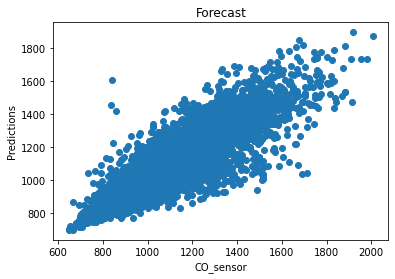

In [12]:
# PLot the predictions vs the truth.

plt.scatter(X_train["CO_sensor"], preds)
plt.xlabel("CO_sensor")
plt.ylabel("Predictions")
plt.title("Forecast")

## Capture the first hr prediction.

To carry out multi-step forecasting, we make the prediction for the next hour, and then that value becomes a new feature that we can use to predict the concentration in the second hour, and so on.

In [17]:
# Split the data

X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= "2005-03-04"]

In [18]:
# Re-train the feature engineering steps
# and the Lasso on the train data

# Lag the target
X_train = lag1.fit_transform(X_train)

# Fill the missing data
X_train = imputer.fit_transform(X_train)

# Train the Lasso.
lasso.fit(X=X_train["CO_sensor_lag_1"].to_frame(), y=X_train["CO_sensor"])

Lasso(random_state=0)

In [19]:
# The last 2 rows of our training set.

X_train.tail(2)

,CO_sensor,CO_sensor_lag_1
Date_Time,,
2005-03-03 22:00:00,1206.0,1285.0
2005-03-03 23:00:00,1179.0,1206.0


The last **CO_sensor** value in our dataset becomes the input feature to predict CO concentration in the next hr.

Then, we create a mini dataframe with the timestamp for the next hr and the value of CO in the previous hr as an input feature.

In [21]:
step = {
    # the next timestamp, the next hr
    "Date_Time": [X_train.iloc[-1].name + pd.offsets.Hour(1)],
    # the prediction of the previous hr as input feature
    "CO_sensor_lag_1": [X_train.iloc[-1]["CO_sensor"]],
}

step = pd.DataFrame(step)

step

,Date_Time,CO_sensor_lag_1
0,2005-03-04,1179.0


In [22]:
step["CO_sensor_lag_1"]

0    1179.0
Name: CO_sensor_lag_1, dtype: float64

In [23]:
# Now, we make a new prediction based on the last
# input data.

pred = lasso.predict(step["CO_sensor_lag_1"].to_frame())

pred

array([1167.26632992])

Now, this prediction becomes the input feature for the next (second) hour prediction.

In [24]:
# Mini dataframe with the timestamp for the
# next (second) hr and the value of CO in
# the previous hr as an input feature.

step = {
    # the timestamp, now 2 hrs ahead.
    "Date_Time": [X_train.iloc[-1].name + pd.offsets.Hour(2)],
    # the last prediction
    "CO_sensor_lag_1": pred,
}

step = pd.DataFrame(step)

step

,Date_Time,CO_sensor_lag_1
0,2005-03-04 01:00:00,1167.26633


In [18]:
# Now we make a third prediction

pred = lasso.predict(step["CO_sensor_lag_1"].to_frame())

pred

array([1156.92739008])

And we continue on an on.

## Forecasting 24 steps ahead.

Let's now go ahead and predict the next 24 hours of pollutant concentration.

We start by calculating the first hour concentration as we did previously. Then, with this value, we create the next input data, we determine the next concentration, and we repeat this process 24 times.

In [27]:
# Split the data

X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= "2005-03-04"]

In [28]:
# We repeat the process 24 times:

# That is, we predict one hr. ahead,
# create new input data from this prediction,
# then predict the second value ahead,
# create new input data from this prediction
# and continue, until we predict 24 hrs. ahead.

# Fit the engineering steps
X_train = lag1.fit_transform(X_train)
X_train = imputer.fit_transform(X_train)

# Fit the lasso
lasso.fit(X_train["CO_sensor_lag_1"].to_frame(), X_train["CO_sensor"])

steps_ls = []

# The last concentration in the train set is the input
# feature for the first observation in the test set.
step = {
    # the next timestamp, the next hr
    "Date_Time": [X_train.iloc[-1].name + pd.offsets.Hour(1)],
    # the last CO concentration
    "CO_sensor_lag_1": [X_train.iloc[-1]["CO_sensor"]],
}

step = pd.DataFrame(step)

preds_ls = []

for i in range(24):

    # keep for later
    steps_ls.append(step)

    # make prediction for next hr
    pred = lasso.predict(step["CO_sensor_lag_1"].to_frame())

    # save prediction
    preds_ls.append(pred[0])

    # create input data for next hr prediction
    step = {
        "Date_Time": [X_train.iloc[-1].name + pd.offsets.Hour(i + 2)],
        "CO_sensor_lag_1": pred,
    }

    step = pd.DataFrame(step)

In [33]:
# After running the previous loop, we obtain
# our 24 predictions in a list.

# convert list to series
preds = pd.Series(preds_ls)

# add the timestamps
preds.index = pd.concat(steps_ls)["Date_Time"]

preds = pd.DataFrame(preds, columns=["preds"])

preds

,preds
Date_Time,
2005-03-04 00:00:00,1167.266330
2005-03-04 01:00:00,1156.927390
2005-03-04 02:00:00,1147.817395
2005-03-04 03:00:00,1139.790265
2005-03-04 04:00:00,1132.717286
2005-03-04 05:00:00,1126.485040
2005-03-04 06:00:00,1120.993595
2005-03-04 07:00:00,1116.154893
2005-03-04 08:00:00,1111.891347


In [52]:
# We can plot our predictions vs. the truth, which is
# the CO concentration in the test set.

tmp = preds.join(X_test, on="Date_Time")
tmp

,preds,CO_sensor
Date_Time,,
2005-03-04 00:00:00,1167.266330,929.0
2005-03-04 01:00:00,1156.927390,951.0
2005-03-04 02:00:00,1147.817395,938.0
2005-03-04 03:00:00,1139.790265,921.0
2005-03-04 04:00:00,1132.717286,850.0
2005-03-04 05:00:00,1126.485040,811.0
2005-03-04 06:00:00,1120.993595,848.0
2005-03-04 07:00:00,1116.154893,882.0
2005-03-04 08:00:00,1111.891347,936.0


<AxesSubplot:xlabel='Date_Time'>

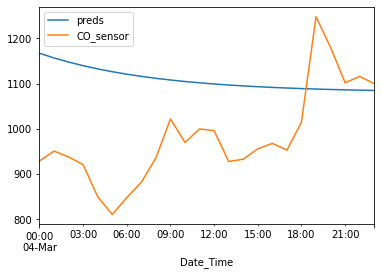

In [53]:
tmp.plot()

Still not an amazing model.

In [54]:
# And now we calculate the RMSE for the 24 hr.
# chunk.

print(
    "rmse: ",
    mean_squared_error(
        tmp["CO_sensor"],
        tmp["preds"].tail(24),
        squared=False,
    ),
)

rmse:  173.9793721322321


# Back-testing with expanding window.

Now, we will make predictions with an expanding window. We will "train" the model up to a certain point, and then make predictions 24hs ahead. We will then "train" the model up to a point further in the future, and make predictions 24hs ahead. And so on.



<img src='../images/backtesting.png' width="600" height="600">


In [55]:
# Capture first day on test set

start = X_test.iloc[0].name
start

Timestamp('2005-03-04 00:00:00')

In [56]:
# capture last day on test set

end = X_test.iloc[-1].name
end

Timestamp('2005-04-04 14:00:00')

In [57]:
# Create a 24 hr date range.

pd.date_range(start=start, end=end, freq="24H")

DatetimeIndex(['2005-03-04', '2005-03-05', '2005-03-06', '2005-03-07',
               '2005-03-08', '2005-03-09', '2005-03-10', '2005-03-11',
               '2005-03-12', '2005-03-13', '2005-03-14', '2005-03-15',
               '2005-03-16', '2005-03-17', '2005-03-18', '2005-03-19',
               '2005-03-20', '2005-03-21', '2005-03-22', '2005-03-23',
               '2005-03-24', '2005-03-25', '2005-03-26', '2005-03-27',
               '2005-03-28', '2005-03-29', '2005-03-30', '2005-03-31',
               '2005-04-01', '2005-04-02', '2005-04-03', '2005-04-04'],
              dtype='datetime64[ns]', freq='24H')

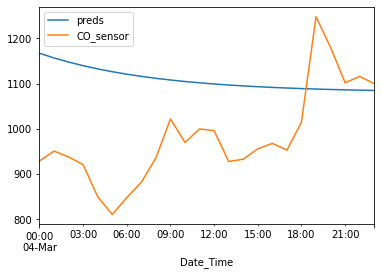

rmse:  232.9819377834542


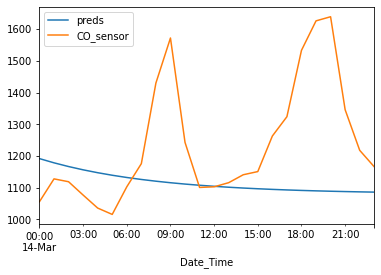

rmse:  207.74844564199913


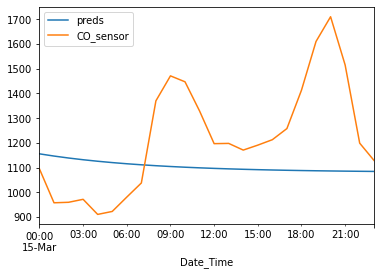

rmse:  113.15715473034247


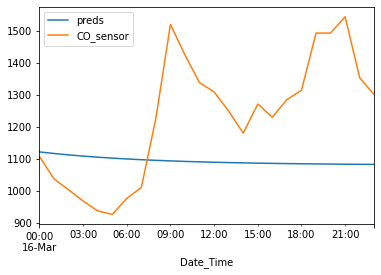

rmse:  86.85812186165053


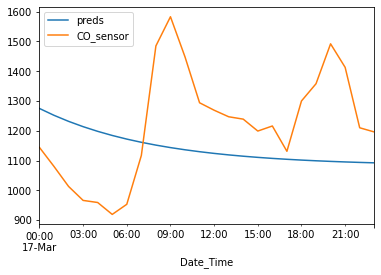

rmse:  89.08259276274649


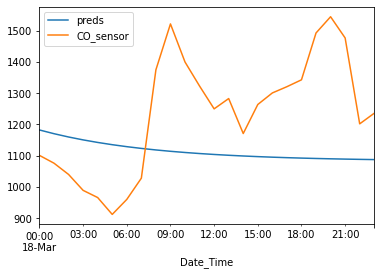

rmse:  68.5051701211911


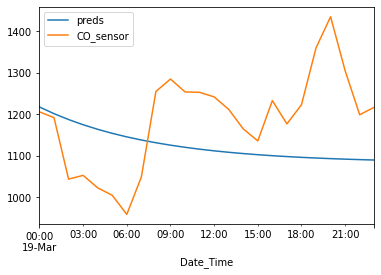

rmse:  103.83199571102028


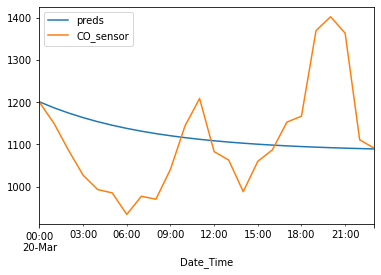

rmse:  112.54369521805002


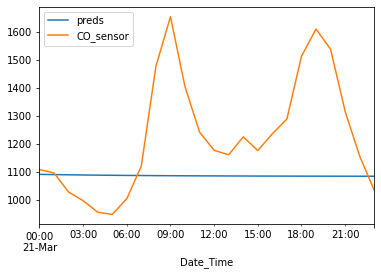

rmse:  211.3261696998268


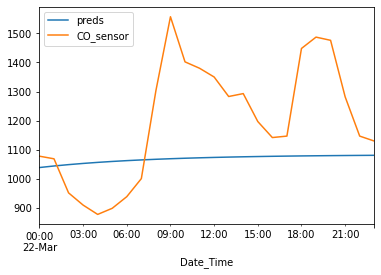

rmse:  93.97207031879206


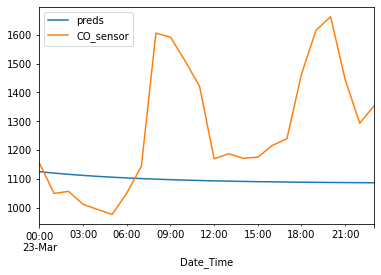

rmse:  130.12686117785213


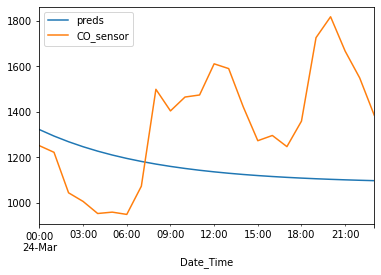

rmse:  171.71779173981943


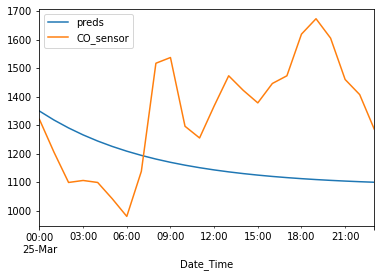

rmse:  143.23916480255437


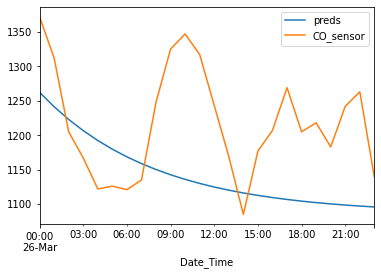

rmse:  222.4117802635463


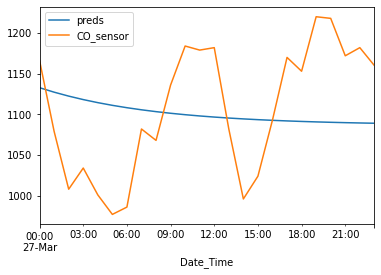

rmse:  130.07770113794805


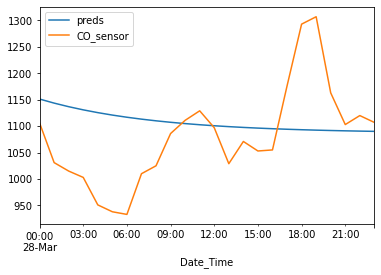

rmse:  61.472893755432295


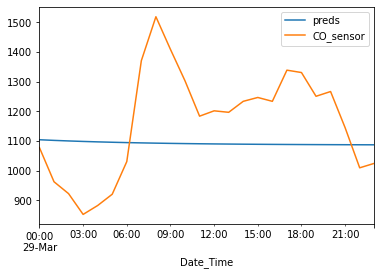

rmse:  178.82859577446408


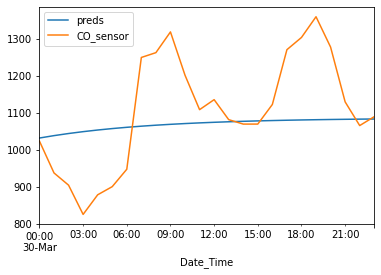

rmse:  97.69638341992673


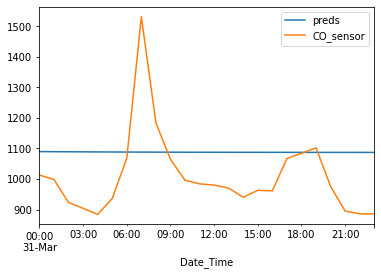

rmse:  171.09512461396048


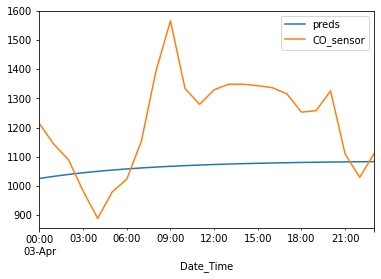

rmse:  176.806391287193


In [58]:
# Now we loop, expanding the training set by 24 hours
# on each round.

rmse_ls = []

# This is the loop over different forecast start dates for
# the purposes of backtesting
for forecast_start_date in pd.date_range(start=start, end=end, freq="24H"):

    # Split the data:
    # Here we perform the expanding window.
    X_train = data[data.index < forecast_start_date]

    # We only select the next 24 hrs of real
    # Pollutant concentration.
    X_test = data[data.index >= forecast_start_date].head(24)

    # Fit the engineering steps.
    X_train = lag1.fit_transform(X_train)
    X_train = imputer.fit_transform(X_train)

    # Fit the lasso.
    lasso.fit(X=X_train["CO_sensor_lag_1"].to_frame(), y=X_train["CO_sensor"])

    steps_ls = []

    # Take last observation from train set to create
    # the first hr input feature.
    step = {
        "Date_Time": [X_train.iloc[-1].name + pd.offsets.Hour(1)],
        "CO_sensor_lag_1": [X_train.iloc[-1]["CO_sensor"]],
    }

    step = pd.DataFrame(step)

    preds_ls = []

    # --- Make predictions ---
    # This loop is used to make our multi-step ahead forecast from the forecast start date
    # A loop is required because each prediction is used as an input to create features
    # for the following period, other than for the first hour where the actuals is used
    for i in range(24):

        steps_ls.append(step)

        # predict concentration in the next hr.
        pred = lasso.predict(step["CO_sensor_lag_1"].to_frame())

        preds_ls.append(pred[0])

        # create, from the last prediction, the input feature
        # for the next hr.
        step = {
            "Date_Time": [X_train.iloc[-1].name + pd.offsets.Hour(i + 2)],
            "CO_sensor_lag_1": pred,
        }

        step = pd.DataFrame(step)

    # Create a dataframe with the 24 hr prediction
    preds = pd.Series(preds_ls)
    preds.index = pd.concat(steps_ls)["Date_Time"]
    preds = pd.DataFrame(preds, columns=["preds"])

    # Now, we check that the test set is aligned with
    # the 24 hr predictions.
    if preds.index.max() == X_test.index.max():

        tmp = pd.concat([preds, X_test.head(24)], axis=1)
        tmp.plot()
        plt.show()

        # We determine the rmse
        rmse_ = mean_squared_error(
            X_test["CO_sensor"],
            X_train["CO_sensor"].tail(24),
            squared=False,
        )
        print("rmse: ", rmse_)

        rmse_ls.append(rmse_)

Now we've got predictions only for those days when we do have 24 hours of real pollutant concentration to be able to compare our forecasts.

To wrap-up, we determine the mean rmse for every day we examined.

In [59]:
# Mean performance during cross-validation

print("rmse: ", np.mean(rmse_ls), "+-", np.std(rmse_ls))
print("Number of days evaluated: ", len(rmse_ls))

rmse:  140.1740020910885 +- 51.740248399424836
Number of days evaluated:  20


The model does not seem amazing, but it is at least a bit better than the naive forecast from the previous notebook. The RMSE is smaller than that obtained with the naive forecast.

In the next notebook, we will extract multiple features from the CO concentration to see if we can improve the forecasting model.
